In [1]:
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
get_ipython().run_line_magic('matplotlib', 'inline')

import datetime
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler

C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\japanize_matplotlib\japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [19]:
df = pd.read_csv('time_series_covid19_confirmed_global_20200714.csv')

In [20]:
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,32672,32951,33190,33384,33594,33908,34194,34366,34451,34455
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,2819,2893,2964,3038,3106,3188,3278,3371,3454,3571
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,15500,15941,16404,16879,17348,17808,18242,18712,19195,19689
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,855,855,855,855,855,855,855,855,855,858
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,346,346,346,386,386,396,458,462,506,525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,Sao Tome and Principe,0.186400,6.613100,0,0,0,0,0,0,...,719,720,721,724,724,726,727,727,729,732
262,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,1248,1265,1284,1297,1318,1356,1380,1389,1465,1498
263,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,...,309,311,311,311,313,314,314,317,317,317
264,NaN,Tajikistan,38.861000,71.276100,0,0,0,0,0,0,...,6159,6213,6262,6315,6364,6410,6457,6506,6552,6596


In [21]:
# 日本のデータのみ抽出する
df = df[df['Country/Region']=='Japan']
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20
139,NaN,Japan,36.204824,138.252924,2,2,2,2,4,4,...,19461,19668,19848,20055,20261,20617,21044,21430,21841,22125


In [24]:
# ５項目目以降（1/22以降）の項目のみにする
df = df.iloc[:,4:].copy()
#１行目の項目を取得
daily_japan=df.iloc[0,:]
# 日付型に変換
daily_japan.index = pd.to_datetime(daily_japan.index)

In [25]:
daily_japan

2020-01-22        2
2020-01-23        2
2020-01-24        2
2020-01-25        2
2020-01-26        4
              ...  
2020-07-09    20617
2020-07-10    21044
2020-07-11    21430
2020-07-12    21841
2020-07-13    22125
Name: 139, Length: 174, dtype: int64

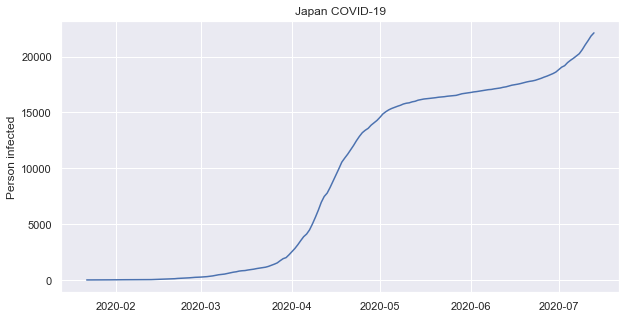

In [26]:
# 日本の感染者数のグラフ
plt.figure(figsize=(10,5))
plt.plot(daily_japan)
plt.title("Japan COVID-19")
plt.grid(True)
plt.ylabel("Person infected")
plt.show()

In [27]:
y=daily_japan.values.astype(float)

In [28]:
# 時系列データを７日をひとつのくくりとして、まとめる。
# ８日目を正解ラベル
def sequence_creator(input_data,window):
    dataset=[]
    data_len = len(input_data)
    for i in range(data_len - window):
        window_fr = input_data[i:i+window]
        label = input_data[i+window:i+window+1]
        dataset.append((window_fr,label))
    return dataset

In [29]:
# LSTMのモデリング
class LSTM_COVID(nn.Module):
    # in_size  ： 入力のノードのサイズ
    # h_size   : 隠れ層のノードのサイズ　（誤差が少なくなるように調整する項目）
    # out_size : 結果のノードのサイズ
    def __init__(self, in_size=1, h_size=30, out_size=1):
        super().__init__()
        
        self.h_size = h_size
        self.lstm = nn.LSTM(in_size, h_size)
        self.fc = nn.Linear(h_size,out_size)
        
        self.hidden = (torch.zeros(1,1,self.h_size), torch.zeros(1,1,self.h_size))
        
    def forward(self, sequence_data):
        lstm_out, self.hidden = self.lstm(sequence_data.view(len(sequence_data),1,-1),self.hidden)
        pred = self.fc(lstm_out.view(len(sequence_data),-1))
        return pred[-1]

# モデルの定義

In [11]:
torch.manual_seed(3)

model = LSTM_COVID()
criterion = nn.MSELoss()
# lr : lrlearning rate)=学習率　どれぐらいの幅でパラメータを更新していくのか（誤差が少なくなるように調整する項目）
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [12]:
window_size = 7
loss_list = []
loss_temp = 0

#model.train()

In [13]:
# 入力の正規化 (-1 から1に収まるように)
scaler = MinMaxScaler(feature_range=(-1,1))
y_normalized = scaler.fit_transform(y.reshape(-1,1))
y_normalized = torch.FloatTensor(y_normalized).view(-1)
full_data = sequence_creator(y_normalized,window_size)

# トレーニング

In [14]:
# 学習の繰り返し
epochs = 300
for epoch in range(epochs):
    # トレーニングデータの件数分ループする
    for sequence_in, y_train in full_data:
        # 予測値計算
        y_pred = model(sequence_in)
        # 損失計算
        loss = criterion(y_pred, y_train)
        loss_temp += loss
        # 勾配を初期化する
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.h_size),torch.zeros(1,1,model.h_size))
        # パラメータを更新する
        loss.backward()
        optimizer.step()
        
    if((epoch+1) % 10 ==0):
        loss_list.append(loss_temp.item()/(10*len(full_data)))
        print(f'Epoch {epoch+1} Loss {loss_temp.item()/(10*len(full_data))}')
        loss_temp = 0


Epoch 10 Loss 0.036233726090299866
Epoch 20 Loss 0.007454320485006549
Epoch 30 Loss 0.004141357558929992
Epoch 40 Loss 0.002365444520276464
Epoch 50 Loss 0.001416138117898724
Epoch 60 Loss 0.0007416072005997161
Epoch 70 Loss 0.0004144098944292811
Epoch 80 Loss 0.00044929513674296304
Epoch 90 Loss 0.0005464370022276919
Epoch 100 Loss 0.0006410067666790442
Epoch 110 Loss 0.0006673867117145104
Epoch 120 Loss 0.0005853569079302028
Epoch 130 Loss 0.0005124076754747037
Epoch 140 Loss 0.0004594331372997718
Epoch 150 Loss 0.0004070599992832024
Epoch 160 Loss 0.00035646497132535464
Epoch 170 Loss 0.0003103766255749914
Epoch 180 Loss 0.0002697886107210628
Epoch 190 Loss 0.00023317428049213158
Epoch 200 Loss 0.00020156843576602594
Epoch 210 Loss 0.0001752058367529315
Epoch 220 Loss 0.0001541097185568895
Epoch 230 Loss 0.00013740281323472897
Epoch 240 Loss 0.00012391621838072817
Epoch 250 Loss 0.00011256217599628928
Epoch 260 Loss 0.00010358677831238616
Epoch 270 Loss 9.698720570809827e-05
Epoch 2

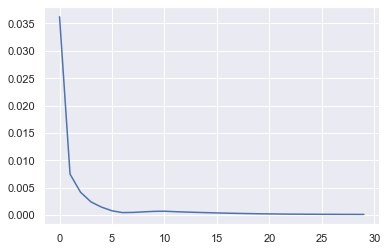

In [23]:
# ロスのプロット
plt.plot(loss_list)

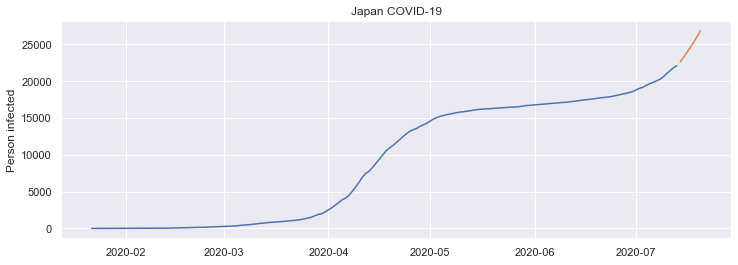

In [34]:
# 将来の７日間の予測
upcoming_future = 7
predictions = y_normalized[-window_size:].tolist()

model.eval()

for i in range(upcoming_future):
    sequence = torch.FloatTensor(predictions[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.h_size),torch.zeros(1,1,model.h_size))
        predictions.append(model(sequence).item())
        
predictions_y = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
# 7/14　～　7/20　まで（７日間）の予測値を指定する
x = np.arange('2020-07-14','2020-07-21', dtype='datetime64[D]').astype('datetime64[D]')
sns.set()
plt.figure(figsize = (12,4))
plt.title("Japan COVID-19")
plt.grid(True)
plt.ylabel("Person infected")
plt.plot(daily_japan)
plt.plot(x,predictions_y[-window_size:])
plt.show()

In [35]:
# 予測値
predictions_y[-window_size:]

array([[22629.01207381],
       [23244.50274712],
       [23935.32827413],
       [24625.86502039],
       [25319.36341763],
       [26055.70949364],
       [26869.35255009]])